<a href="https://colab.research.google.com/github/jglaser2/ssm/blob/multipop/notebooks/mp_rslds_simulation_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### If you want to quickly see how to fit your own data, jump down to the "Fit model to data" section
<br />
<br />

# Multi-population recurrent switching linear dynamical systems overview

This notebook goes through the simulation example shown in our manuscript (Figure 2A,B).

Below, we briefly describe the model. We also recommend looking at the "Recurrent SLDS" notebook, which provides more details on the standard rSLDS.
<br />
<br />

**1. Data**.
Let $y_t^{_{(j)}}$ denote a vector of activity measurements of the $N_j$ neurons in population $j$ in time bin $t$.
<br />

**2. Emissions**. 
let $x_t^{_{(j)}}$ denote a continuous latent state of population $j$ at time $t$. The population states may differ in dimensionality~$D_j$, since populations may differ in size and complexity. The observed activity of population $j$ is modeled with a generalized linear model,
\begin{align}
    E[y_t^{(j)}] &= f(C_j x_t^{(j)} + d_j),
\end{align}
where each population has its own linear mapping parameterized by $\{C_j, d_j\}$. In this notebook, we use a Poisson GLM. Inputs can also be passed into this GLM, as described in the rSLDS notebook.

There are multi-population emissions classes that will be loaded in the example below.
<br />

**3. Continuous State Update (Dynamics)**. 
The dynamics of a switching linear dynamical system are piecewise linear, with the linear dynamics at a given time determined by a discrete state, (more on discrete states below).

\begin{align}
    x_t \sim 
    A^{(z_t)} x_{t-1} + b^{(z_t)}
\end{align} 

where $z_t$ is the discrete state, $A^{(z_t)}$ is the dynamics for that discrete state, and $x_t$ contains the latents from all populations, $[x_t^1, x_t^2, ..., x_t^J]$. We ignore the noise term here for simplicity.

Having unique continuous latents for each population allows us to decompose the dynamics in an interpretable manner. We model the temporal dynamics of the continuous states as
\begin{align}
    x_t^{(j)} \sim
    A_{(j \: to \: j)}^{(z_t)} x_{t-1}^{(j)} 
    + \sum_{i \neq j} A_{(i \: to \: j)}^{(z_t)} x_{t-1}^{(i)} 
    + b_j^{(z_t)}.
\end{align} 

In the full dynamics matrices, $A^{(z_t)}$ we will show in the example below, the on-diagonal blocks represent the internal dynamics, $A_{(j \: to \: j)}^{(z_t)}$ and the off-diagonal blocks represent the external dynamics, $A_{(i \: to \: j)}^{(z_t)}$.


**4. Discrete State Update (Transitions)**. 
Recurrent transitions are based on the continuous latent state. Our recurrent transitions have a sticky component, $S$ that determines the probabilities of staying in a state, and a switching component, $R$, that determines the probabilities of switching to states. In the model we use in this notebook:

\begin{align}
    p(z_t = i \mid z_{t-1} = j, x_{t-1}) &= \mathrm{softmax}\bigg\{ \Big( \big(R x_{t-1}\big) + r\Big) \odot (1 - e_{z_{t-1}})  + \Big( \big(S x_{t-1} \big) + s \Big) \odot e_{z_{t-1}}  \bigg\},
\end{align}

where $e_{z_{t-1}} \in \{0,1\}^K$ is a one-hot encoding of $z_{t-1}$.

To understand which populations are contributing to the transitions, we can decompose this equation:


\begin{align}
    p(z_t = i \mid z_{t-1} = j, x_{t-1}) &= \mathrm{softmax}\bigg\{ \Big( \sum_{j=1}^J \big(R_j x_{t-1}^{(j)}\big) + r\Big) \odot (1 - e_{z_{t-1}})  + \Big( \sum_{j=1}^J \big(S_j x_{t-1}^{(j)} \big) + s \Big) \odot e_{z_{t-1}}  \bigg\},
\end{align}
where, for example, $R_j x_{t-1}^{(j)}$ contains the contribution of population $j$ towards switching to each state.


Additionally, we can include a dependency on the previous discrete state. This is included in the code package, but is not used in the example below.

\begin{align}
    p(z_t = i \mid z_{t-1} = j, x_{t-1}) &= \mathrm{softmax}\bigg\{ \log(P_{j,i}) +  \big(R x_{t-1}\big) \odot (1 - e_{z_{t-1}})  + \big(S x_{t-1} \big) \odot e_{z_{t-1}}  \bigg\},
\end{align}

There are sticky multi-population emissions classes that will be loaded in the example below.
<br />

**5. Model fitting**. 
We fit the model with variational laplace EM - see the "Variational Laplace EM for SLDS Tutorial" for more information.


## Import packages, including multipopulation extensions

In [1]:
try:
    import ssm
except:
    !pip install git+https://github.com/jglaser2/ssm.git@multipop#egg=ssm
    import ssm

In [2]:
#### General packages

from matplotlib import pyplot as plt
%matplotlib inline
import autograd.numpy as np
import autograd.numpy.random as npr

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")
sns.set_style('ticks',{"xtick.major.size":8,
"ytick.major.size":8})
from ssm.plots import gradient_cmap, white_to_color_cmap

color_names = [
    "purple",
    "red",
    "amber",
    "faded green",
    "windows blue",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
#### SSM PACKAGES ###

import ssm
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior, \
    SLDSStructuredMeanFieldVariationalPosterior
from ssm.util import random_rotation, find_permutation, relu

#Load from extensions
from ssm.extensions.mp_srslds.emissions_ext import GaussianOrthogonalCompoundEmissions, PoissonOrthogonalCompoundEmissions
from ssm.extensions.mp_srslds.transitions_ext import StickyRecurrentOnlyTransitions, StickyRecurrentTransitions

## Simulate (somewhat realistic) data

### Set parameters of simulation

In [4]:
K=3 #Number of discrete states

num_gr=3 #Number of populations
num_per_gr=5 #Number of latents per population
neur_per_gr=75 #Number of neurons per population

t_end=3000 #number of time bins
num_trials=1 #number of trials

In [5]:
np.random.seed(108) #To create replicable dynamics

alphas=.03+.1*np.random.rand(K) #Determines the distribution of values in the dynamics matrix, for each discrete state
print('alphas:', alphas)

sparsity=.33 #Proportion of non-diagonal blocks in the dynamics matrix that are 0

e1=.1 #Amount of noise in the dynamics

alphas: [0.05336111 0.03343876 0.08800889]


### Get new emissions and transitions classes for the simulated data

In [6]:
#Vector containing number of latents per population
D_vec=[]
for i in range(num_gr):
    D_vec.append(num_per_gr) 

#Vector containing number of neurons per population
N_vec=[]
for i in range(num_gr):
    N_vec.append(neur_per_gr)

D=np.sum(D_vec)
num_gr=len(D_vec)
D_vec_cumsum = np.concatenate(([0], np.cumsum(D_vec)))

#Get new multipopulation emissions class for the simulation

# gauss_comp_emissions=GaussianOrthogonalCompoundEmissions(N=np.sum(N_vec),K=1,D=np.sum(D_vec),D_vec=D_vec,N_vec=N_vec)
poiss_comp_emissions=PoissonOrthogonalCompoundEmissions(N=np.sum(N_vec),K=1,D=np.sum(D_vec),D_vec=D_vec,N_vec=N_vec,link='softplus')

#Get transitions class
true_sro_trans=StickyRecurrentOnlyTransitions(K=K,D=np.sum(D_vec)) 

### Create simulated data

In [7]:
np.random.seed(10) #To create replicable simulations

A_masks=[]

A_all=np.zeros([K,D,D]) #Initialize dynamics matrix
b_all=np.zeros([K,D]) #Initialize dynamics offset


#Create initial ground truth model, that we will modify
true_slds = ssm.SLDS(N=np.sum(N_vec),K=K,D=int(np.sum(D_vec)),
             dynamics="gaussian",
             emissions=poiss_comp_emissions,
             transitions=true_sro_trans)

#Create ground truth transitions
v=.2+.2*np.random.rand(1)
for k in range(K):
    inc=np.copy(k)
    true_slds.transitions.Rs[k,D_vec_cumsum[inc]:D_vec_cumsum[inc]+1]=v
    true_slds.transitions.Ss[k,D_vec_cumsum[inc]:D_vec_cumsum[inc]+1]=v-.1

true_slds.transitions.r=0*np.ones([K,1])
true_slds.transitions.s=5*np.ones([K,1])

#Create ground truth dynamics for each state
for k in range(K):

    ##Create dynamics##
    alpha=alphas[k]

    A_mask=np.random.rand(num_gr,num_gr)>sparsity #Make some blocks of the dynamics matrix 0

    A_masks.append(A_mask)

    for i in range(num_gr): 
        A_mask[i,i]=1

    A0=np.zeros([D,D])
    for i in range(D-1):
        A0[i,i+1:]=alpha*np.random.randn(D-1-i)
    A0=(A0-A0.T)

    for i in range(num_gr):
        A0[D_vec_cumsum[i]:D_vec_cumsum[i+1],D_vec_cumsum[i]:D_vec_cumsum[i+1]]=2*A0[D_vec_cumsum[i]:D_vec_cumsum[i+1],D_vec_cumsum[i]:D_vec_cumsum[i+1]]


    A0=A0+np.identity(D)
    A=A0*np.kron(A_mask, np.ones((num_per_gr, num_per_gr)))

    A=A/(np.max(np.abs(np.linalg.eigvals(A)))+.01) #.97

    b=1*np.random.rand(D)

    A_all[k]=A
    b_all[k]=b

true_slds.dynamics.As=A_all
true_slds.dynamics.bs=b_all


zs, xs, _ = true_slds.sample(t_end) #Sample discrete and continuous latents from model for simulation

#Get spike trains that have an average firing rate of 0.25 per bin
tmp=np.mean(relu(np.dot(true_slds.emissions.Cs[0],xs.T)+.1*true_slds.emissions.ds[0][:,None]).T)
mult=.25/tmp
lams=relu(mult*np.dot(true_slds.emissions.Cs[0],xs.T)+.1*true_slds.emissions.ds[0][:,None]).T
ys=np.random.poisson(lams) #Get spiking activity based on poisson statistics

## Plot simulated data

### Dynamics matrices ($A^z$)

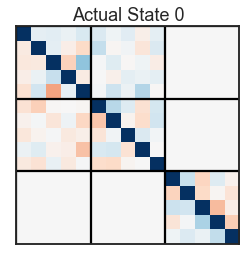

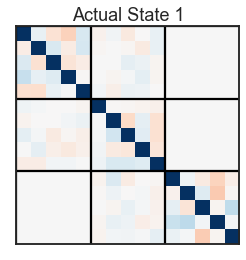

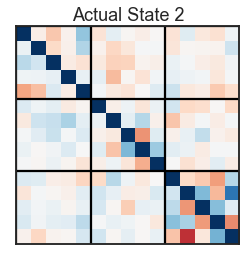

In [8]:
# vmin,vmax=[-1,1]
vmin,vmax=[-.5,.5] #zoom in to see colors more clearly


for k in range(K):
    
    plt.figure(figsize=(4,4))
    plt.imshow(true_slds.dynamics.As[k], aspect='auto', interpolation="none", vmin=vmin, vmax=vmax, cmap='RdBu')
    offset=-.5
    for nf in D_vec:        
        plt.plot([-0.5, D-0.5], [offset, offset], '-k')
        plt.plot([offset, offset], [-0.5, D-0.5], '-k')
        offset += nf
    plt.xticks([])
    plt.yticks([])
    plt.title('Actual State '+str(k))

### Discrete states ($z$)

([], <a list of 0 Text major ticklabel objects>)

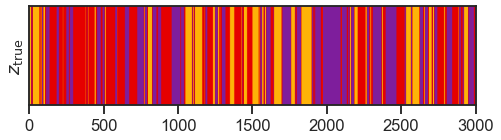

In [9]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

### Transitions (in a shorter time window)
The contribution of population $j$ to staying in a state is $S_j x^{j}$ and the contribution to switching to a state is $R_j x^{j}$

In [10]:
dur=200
st_t=650
end_t=st_t+dur

([], <a list of 0 Text major ticklabel objects>)

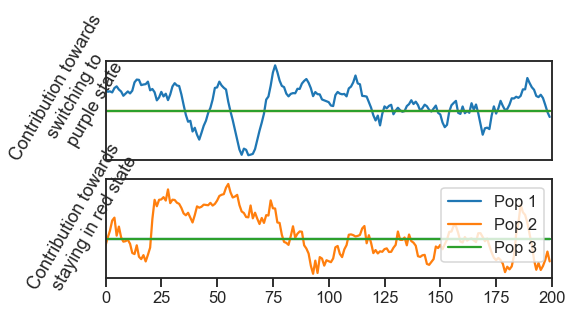

In [11]:
plt.figure(figsize=(8, 4))

j=0

plt.subplot(211)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Contribution towards \n switching to \n purple state',rotation=60)
plt.xticks([])
plt.yticks([])

j=1
plt.subplot(212)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Ss[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Contribution towards \n staying in red state',rotation=60)
plt.legend(['Pop 1','Pop 2','Pop 3'])
plt.yticks([])

### Continuous latents ($x$) and spikes ($y$) for an example population

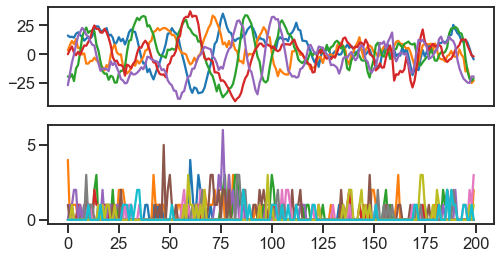

In [12]:
plt.figure(figsize=(8, 4))

plt.subplot(211)
plt.plot(xs[st_t:end_t,:num_per_gr]) #Show latents of first group
plt.xticks([])

plt.subplot(212)
plt.plot(ys[st_t:end_t,:10]) #Show first 10 neurons


## Fit model to data

#### To create the emissions classes for the multipopulation models, we need vectors containing the number of continuous latents per population ("D_vec") and neurons per population ("N_vec")


In [13]:
num_gr=3 #Number of populations
num_per_gr=5 #Number of latents per population
neur_per_gr=75 #Number of neurons per population

#Vector containing number of latents per population
D_vec=[]
for i in range(num_gr):
    D_vec.append(num_per_gr) 

#Vector containing number of neurons per population
N_vec=[]
for i in range(num_gr):
    N_vec.append(neur_per_gr)

#### Now create the multipopulation emissions and transitions classes for our model

In [14]:
#Get new multipopulation emissions class
poiss_comp_emissions=PoissonOrthogonalCompoundEmissions(N=np.sum(N_vec),K=1,D=np.sum(D_vec),D_vec=D_vec,N_vec=N_vec,link='softplus')

#Get new transitions class
sro_trans=StickyRecurrentOnlyTransitions(K=K,D=np.sum(D_vec), l2_penalty_similarity=10, l1_penalty=10) 
#The above l2 penalty is on the similarity between R and S (its assuming the activity to switch into a state is similar to activity to stay in a state)
#The L1 penalty is on the entries of R and S

#### Now declare and fit the model

In [ ]:
K=3 #Number of discrete states

rslds = ssm.SLDS(N=np.sum(N_vec),K=K,D=np.sum(D_vec),
             dynamics="gaussian",
             emissions=poiss_comp_emissions,
             transitions=sro_trans,
             dynamics_kwargs=dict(l2_penalty_A=100)) #Regularization on the dynamics matrix

q_elbos_ar, q_ar = rslds.fit(ys, method="laplace_em",
                             variational_posterior="structured_meanfield", 
                             continuous_optimizer='newton',
                             initialize=True, 
                             num_init_restarts=10,
                             num_iters=30, 
                             alpha=0.25)

Initializing with an ARHMM using 25 steps of EM.



Initializing with an ARHMM using 25 steps of EM.



Initializing with an ARHMM using 25 steps of EM.



Initializing with an ARHMM using 25 steps of EM.



Initializing with an ARHMM using 25 steps of EM.



Initializing with an ARHMM using 25 steps of EM.



Initializing with an ARHMM using 25 steps of EM.



Initializing with an ARHMM using 25 steps of EM.



Initializing with an ARHMM using 25 steps of EM.



Initializing with an ARHMM using 25 steps of EM.


In [ ]:
plt.plot(q_elbos_ar[1:])
plt.xlabel("Iteration")
plt.ylabel("ELBO")

## Align solution with simulation for plotting

In [ ]:
#The recovered discrete states can be permuted in any way. 
#Find permutation to match the discrete states in the model and the ground truth
z_inferred=rslds.most_likely_states(q_ar.mean_continuous_states[0],ys)
rslds.permute(find_permutation(zs, z_inferred))
z_inferred2=rslds.most_likely_states(q_ar.mean_continuous_states[0],ys)

In [ ]:
#Each population's latents can be multiplied by an arbitrary rotation matrix
#Additionally, there may be a change in scaling between the simulation ground truth and recovered latents,
#because the simulation didn't constrain the effective emissions (C) matrix to be orthonormal like in the model

from sklearn.linear_model import LinearRegression

R=np.zeros([D,D])
for g in range(num_gr):
    lr=LinearRegression(fit_intercept=False)
    lr.fit(q_ar.mean_continuous_states[0][:,D_vec_cumsum[g]:D_vec_cumsum[g+1]],xs[:,D_vec_cumsum[g]:D_vec_cumsum[g+1]])
    R[D_vec_cumsum[g]:D_vec_cumsum[g+1],D_vec_cumsum[g]:D_vec_cumsum[g+1]]=lr.coef_

## Plot results

### Discrete states ($z$)

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(z_inferred2[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, t_end)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [ ]:
print('Discrete state accuracy: ', np.mean(zs==z_inferred2))

#### Shorter time window

In [ ]:
plt.figure(figsize=(4, 2))
plt.subplot(211)
plt.imshow(zs[None,st_t:end_t], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, dur)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.xticks([])

plt.subplot(212)
plt.imshow(z_inferred2[None,st_t:end_t], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, dur)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])

### Dynamics matrices ($A^z$)

We show the A matrix from when the continuous latents are aligned to ground truth, demonstrating the ability to recover the ground truth dynamics.

We also show the original recovered A matrix, which demonstrates that we can learn about the block structure, regardless of scaling/rotations.

In [ ]:
plt.figure(figsize=(12, 12))

q=1

for k in range(K):
    
    plt.subplot(3,3,q)
    plt.imshow(true_slds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')
    offset=-.5
    for nf in D_vec:        
        plt.plot([-0.5, D-0.5], [offset, offset], '-k')
        plt.plot([offset, offset], [-0.5, D-0.5], '-k')
        offset += nf
    plt.xticks([])
    plt.yticks([])
    plt.title('Actual State '+str(k))
    
    q=q+1

    plt.subplot(3,3,q)
#     plt.imshow(rslds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')
    plt.imshow(R@rslds.dynamics.As[k]@np.linalg.inv(R), aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')

    offset=-.5
    for nf in D_vec:        
        plt.plot([-0.5, D-0.5], [offset, offset], '-k')
        plt.plot([offset, offset], [-0.5, D-0.5], '-k')
        offset += nf
    plt.xticks([])
    plt.yticks([])
    plt.title('Aligned Predicted State '+str(k))
#     plt.savefig(folder+'dyn_est'+str(k)+'.pdf')    

    q=q+1


    plt.subplot(3,3,q)
#     plt.imshow(rslds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')
    plt.imshow(rslds.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='RdBu')

    offset=-.5
    for nf in D_vec:        
        plt.plot([-0.5, D-0.5], [offset, offset], '-k')
        plt.plot([offset, offset], [-0.5, D-0.5], '-k')
        offset += nf
    plt.xticks([])
    plt.yticks([])
    plt.title('Raw Predicted State '+str(k))
#     plt.savefig(folder+'dyn_est'+str(k)+'.pdf')
    
    q=q+1
    
    

        


### Transitions
The contribution of population $j$ to staying in a state is $S_j x^{j}$ and the contribution to switching to a state is $R_j x^{j}$


In [ ]:
plt.figure(figsize=(15, 4))


### Actual

j=0

plt.subplot(221)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Contribution towards \n switching to \n purple state',rotation=60)
plt.xticks([])
plt.yticks([])
plt.title('Actual')

j=1
plt.subplot(223)
for g in range(K):
    plt.plot(np.dot(xs[st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],true_slds.transitions.Ss[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
plt.ylabel('Contribution towards \n staying in red state',rotation=60)
plt.legend(['Pop 1','Pop 2','Pop 3'])
plt.yticks([])




### Predicted

j=0

plt.subplot(222)
for g in range(K):
    plt.plot(np.dot(q_ar.mean_continuous_states[0][st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],rslds.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
# plt.ylabel('Contribution towards \n switching to \n purple state',rotation=60)
plt.xticks([])
plt.yticks([])
plt.title('Predicted')

j=1
plt.subplot(224)
for g in range(K):
    plt.plot(np.dot(q_ar.mean_continuous_states[0][st_t:end_t,D_vec_cumsum[g]:D_vec_cumsum[g+1]],rslds.transitions.Ss[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, dur)
# plt.ylabel('Stay in Red')
# plt.xticks([])
plt.yticks([])

### Example fit of neural activity ($y$)

In [ ]:
preds=rslds.smooth(q_ar.mean_continuous_states[0],ys) #get predictions

nrn=0 #Example neuron
plt.plot(ys[st_t:end_t,nrn],alpha=.5) #true spiking activity
plt.plot(lams[st_t:end_t,nrn]) #true firing rate
plt.plot(preds[st_t:end_t,nrn]) #predicted firing

plt.legend(['True Spikes','True FR','Predicted FR'])
